<a href="https://colab.research.google.com/github/rubenguerra/datascience/blob/master/Generar_imagenes_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
try:
  # %esta versión solo existe en colaboratory
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.0.0-beta1'

In [ ]:
# Para generar GIFs
!pip install -q imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
## Se carga y prepara el dataset
## Se usarán un dataset de MNIST para entrenar el generador y el discriminador
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 #Se normaliza la imagen a [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
## Creación de los modelos
## El generador y el discrminador son definidos usando Keras Sequential API.
## El generador usa tf.keras.layers.Conv2DTranspose para las capas, y producir una imagen con la alimentación
## Comienza con una capa Dense que toma esta alimentación como entrada
## Se usa la función de activación LeakyRelU para cada capa, excepto en la capa de salida 
## en la que se usa tanh

## FUNCIÓN PARA CREAR EL GENERADOR
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)# None = el tamaño de inicio del lote(batch)
  
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
        
  #Capa de salida
  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)
            
  return model
            
          

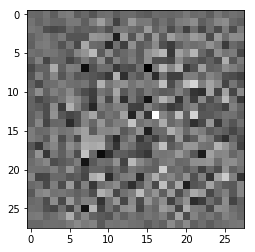

In [ ]:
# Se usa el generador sin entrenar para crear una imagen

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
#EL DISCRIMINADOR

# El discrimador es una red neuronal convulucional de base para clasificar la imagen

def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                         input_shape=[28, 28, 1]))
  
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  
  return model

In [ ]:
## USO DEL DISCRIMINADOR
## aun sin entrenar para clasificar una imagen generada como real o fraudulenta
## El modelo se entrenara para arrojar valores positivos para imagenes realesy
## y valores negativos para imagenes que no lo son

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00050336]], shape=(1, 1), dtype=float32)


In [ ]:
## SE DEFINEN LA PERDIDA Y EL OPTIMIZADOR
## para ambos modelos

#Este metodo regresa una función de ayuda para calcular el valor de cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
#Esta función cuantifica cuan bien el discriminador está habilitado para distinguir
#una imagen real de otra que no lo es.
# Compara la predicción del discriminador de la imagen real en un array de 1s,
# y la predicción del discriminador para una falsa en un array de 0s

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
## La pérdida generada cuantifica cuan bien estuvo el desempeño del discriminador
## Si el generador se desempeña bien, el discriminador clasificará las imagenes falsas como reales (o 1)
## Compararemos las decisiones del discriminador en la generación de imagenes en un array de 1s

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
# El optimizador de discriminador y del generador son diferentes desde que entrenamos
# las dos redes por separado

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# GUARDANDO PUNTOS DE CONTROL
# Se programa cómo guardar y restaurar modelos en el caso de que tome mucho tiempo el entrenamiento
# o se interrumpa

checkpoint_dir = './checkpoints_entrenamiento'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)


In [ ]:
# SE DEFINE EL CICLO DE ENTRENAMIENTO

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Reusamos la alimentación para visualizar el progreso en el GIF animado
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
## El ciclo de entrenamiento comienza con el generador recibiendo una alimentación de entrada.
## Esta es usada para producir una imagen. El discriminador es entonces usado para clasificar
## la imagen real (dibujada por el conjunto de entrenamiento) y las imágenes falsas (producidos por
## ek generador). La pérdida es calculada para cada uno de los modelos, y el gradiente es usado
## para actualizar el generador y el discriminador

# El uso de tf.function produce que la función sea 'compilada'

@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    for image_batch in dataset:
      train_step(image_batch)
      
      
    # Produce imagenes para el GIF
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epoch + 1,
                            seed)
    
    
    # Guarda el modelo cada 15 epocas
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      
      
    print('Tiempo por epoca {} es {} sec'.format(epoch+1, time.time()-start))
    
    # Se genera después de la epoca final
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

In [ ]:
## Esta función genera y guarda las imagenes

def generate_and_save_images(model, epoch, test_input):
  # Note que training esta en Falso
  
  predictions = model(test_input, training=False)
  
  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

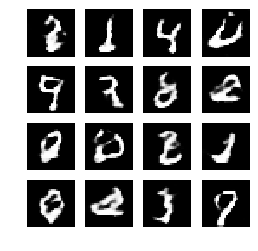

CPU times: user 2min 56s, sys: 48 s, total: 3min 44s
Wall time: 10min 20s


In [ ]:
## SE ENTRENAN EL GENERADO Y EL DISCRIMINADOR SIMULTANEAMENTE

%%time
train(train_dataset, EPOCHS)

In [ ]:
## SE CREA UN GIF

# Despliega uuna simple imagen usando el numero de epocas

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

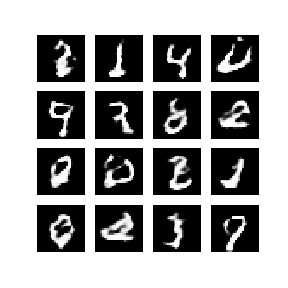

In [ ]:
display_image(EPOCHS)

In [ ]:
# Se usa imageio para crear un gif animado usando la imagen guardada durante el entrenamiento

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i, filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
  
import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)
 

In [ ]:
# AL trabajar en colaboratory se puede bajar la animación con el codigo siguiente

try:
  from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)